# Model Training

Select and train the best fraud detection model.

**Output:** Trained model saved to `models/fraud_detector.joblib`

## 1. Setup

In [1]:
import sys
sys.path.insert(0, '..')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
from pathlib import Path

from src.data import DataLoader
from src.train import Trainer, TrainConfig, ModelType
from src.evaluate import Evaluator

PROCESSED_DIR = Path('../data/processed')
MODELS_DIR = Path('../models')
MODELS_DIR.mkdir(exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')

# Setup MLflow
mlflow.set_experiment("fraud-detection-notebook")
print("MLflow tracking enabled")

2025/12/14 21:08:00 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/14 21:08:00 INFO mlflow.store.db.utils: Updating database tables
2025/12/14 21:08:00 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/14 21:08:00 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/14 21:08:00 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/14 21:08:00 INFO alembic.runtime.migration: Will assume non-transactional DDL.


MLflow tracking enabled


In [2]:
# Load features
loader = DataLoader()
df = loader.load_parquet(PROCESSED_DIR / 'features.parquet')

print(f"Loaded {len(df):,} rows, {len(df.columns)} columns")
print(f"\nClass distribution:")
print(df['is_fraud'].value_counts())
print(f"\nFraud rate: {df['is_fraud'].mean()*100:.2f}%")

Loaded 1,852,394 rows, 17 columns

Class distribution:
is_fraud
0    1842743
1       9651
Name: count, dtype: int64

Fraud rate: 0.52%


In [3]:
# Split data
X_train, X_test, y_train, y_test = loader.split(df)

print(f"Train: {len(X_train):,} rows")
print(f"Test: {len(X_test):,} rows")
print(f"\nTrain fraud rate: {y_train.mean()*100:.2f}%")
print(f"Test fraud rate: {y_test.mean()*100:.2f}%")

Train: 1,481,915 rows
Test: 370,479 rows

Train fraud rate: 0.52%
Test fraud rate: 0.52%


## 2. Baseline Model

Train without any class imbalance handling to see the problem.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score

# No class weight, no SMOTE
with mlflow.start_run(run_name="baseline_no_balancing"):
    baseline = LogisticRegression(max_iter=1000, random_state=42)
    baseline.fit(X_train, y_train)

    y_pred = baseline.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    
    mlflow.log_params({"model": "logistic_regression", "class_weight": None, "smote": False})
    mlflow.log_metrics({"recall": recall, "precision": precision, "TN": cm[0,0], "FP": cm[0,1], "FN": cm[1,0], "TP": cm[1,1]})
    
    print("Baseline (no imbalance handling):")
    print(classification_report(y_test, y_pred, target_names=['Legit', 'Fraud']))
    print(f"Confusion Matrix:")
    print(f"  TN: {cm[0,0]:,}  FP: {cm[0,1]:,}")
    print(f"  FN: {cm[1,0]:,}  TP: {cm[1,1]:,}")
    
    # Dynamic finding
    print(f"\n--- Finding ---")
    if recall < 0.5:
        print(f"Model catches only {recall*100:.1f}% of fraud (recall={recall:.3f}).")
        print(f"Missed {cm[1,0]:,} fraud cases. Class imbalance handling needed.")
    else:
        print(f"Model catches {recall*100:.1f}% of fraud. Baseline performs reasonably.")

Baseline (no imbalance handling):
              precision    recall  f1-score   support

       Legit       0.99      1.00      1.00    368549
       Fraud       0.32      0.03      0.06      1930

    accuracy                           0.99    370479
   macro avg       0.66      0.52      0.53    370479
weighted avg       0.99      0.99      0.99    370479

Confusion Matrix:
  TN: 368,423  FP: 126
  FN: 1,871  TP: 59

--- Finding ---
Model catches only 3.1% of fraud (recall=0.031).
Missed 1,871 fraud cases. Class imbalance handling needed.


## 3. Class Imbalance Handling

Compare two approaches:
| Approach | How | Pros | Cons |
|----------|-----|------|------|
| Class weights | Penalize minority misclassification | No data change | May not be enough |
| SMOTE | Create synthetic minority samples | More fraud examples | Synthetic data |

In [5]:
from sklearn.metrics import average_precision_score, f1_score

results = []

# Approach 1: Class weights
with mlflow.start_run(run_name="class_weights"):
    model_weights = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    model_weights.fit(X_train, y_train)
    y_proba_weights = model_weights.predict_proba(X_test)[:, 1]
    y_pred_weights = model_weights.predict(X_test)
    
    pr_auc_weights = average_precision_score(y_test, y_proba_weights)
    f1_weights = f1_score(y_test, y_pred_weights)
    
    mlflow.log_params({"model": "logistic_regression", "class_weight": "balanced", "smote": False})
    mlflow.log_metrics({"pr_auc": pr_auc_weights, "f1": f1_weights})
    
    results.append({'approach': 'Class Weights', 'pr_auc': pr_auc_weights, 'f1': f1_weights})

# Approach 2: SMOTE
with mlflow.start_run(run_name="smote"):
    X_train_smote, y_train_smote = loader.apply_smote(X_train, y_train, sampling_strategy=0.5)
    print(f"After SMOTE: {len(X_train_smote):,} rows")
    print(f"Fraud ratio: {y_train_smote.mean()*100:.1f}%")

    model_smote = LogisticRegression(max_iter=1000, random_state=42)
    model_smote.fit(X_train_smote, y_train_smote)
    y_proba_smote = model_smote.predict_proba(X_test)[:, 1]
    y_pred_smote = model_smote.predict(X_test)
    
    pr_auc_smote = average_precision_score(y_test, y_proba_smote)
    f1_smote = f1_score(y_test, y_pred_smote)
    
    mlflow.log_params({"model": "logistic_regression", "class_weight": None, "smote": True, "smote_ratio": 0.5})
    mlflow.log_metrics({"pr_auc": pr_auc_smote, "f1": f1_smote})
    
    results.append({'approach': 'SMOTE', 'pr_auc': pr_auc_smote, 'f1': f1_smote})

results_df = pd.DataFrame(results)
display(results_df)

# Dynamic finding - use PR-AUC (better for imbalanced data)
print(f"\n--- Finding ---")
better = results_df.loc[results_df['pr_auc'].idxmax(), 'approach']
pr_diff = abs(pr_auc_weights - pr_auc_smote)
if pr_diff < 0.02:
    print(f"Both approaches perform similarly (PR-AUC diff: {pr_diff:.3f}).")
    print("Using class weights - simpler, no synthetic data.")
else:
    print(f"{better} performs better (PR-AUC: {results_df['pr_auc'].max():.3f}).")
chosen = "class_weights" if pr_auc_weights >= pr_auc_smote else "smote"
print(f"Selected approach: {chosen}")

After SMOTE: 2,211,291 rows
Fraud ratio: 33.3%


,approach,pr_auc,f1
0,Class Weights,0.206764,0.069820
1,SMOTE,0.184604,0.220891



--- Finding ---
Class Weights performs better (PR-AUC: 0.207).
Selected approach: class_weights


## 4. Model Comparison

Compare 4 models using stratified 2-fold cross-validation.

In [6]:
# Sample before split for faster model comparison
SAMPLE_SIZE = 10000
df_sample = df.sample(SAMPLE_SIZE, random_state=42)
X_sample, X_sample_test, y_sample, y_sample_test = loader.split(df_sample)

print(f"Sampled {SAMPLE_SIZE:,} rows for model comparison (full data: {len(df):,})")
print(f"Sample train: {len(X_sample):,}, Sample test: {len(X_sample_test):,}")
print(f"Sample fraud rate: {y_sample.mean()*100:.2f}%")

# Compare all models with MLflow tracking (using PR-AUC - better for imbalanced data)
with mlflow.start_run(run_name="model_comparison"):
    comparison = Trainer.compare_models(X_sample, y_sample, cv_folds=2, scoring='average_precision')
    
    for _, row in comparison.iterrows():
        mlflow.log_metric(f"{row['model']}_pr_auc", row['mean_score'])

print("\nPR-AUC Scores (2-fold CV):")
display(comparison.rename(columns={'mean_score': 'mean_pr_auc', 'std_score': 'std_pr_auc'}))

# Dynamic finding
print(f"\n--- Finding ---")
best_model = comparison.iloc[0]['model']
best_pr_auc = comparison.iloc[0]['mean_score']
print(f"Best model: {best_model} (PR-AUC={best_pr_auc:.3f})")

Sampled 10,000 rows for model comparison (full data: 1,852,394)
Sample train: 8,000, Sample test: 2,000
Sample fraud rate: 0.54%
[1/4] Training logistic... done (average_precision=0.247)
[2/4] Training random_forest... done (average_precision=0.460)
[3/4] Training xgboost... done (average_precision=0.463)
[4/4] Training neural_net... done (average_precision=0.189)

PR-AUC Scores (2-fold CV):


,model,mean_pr_auc,std_pr_auc
2,xgboost,0.462976,0.019687
1,random_forest,0.460262,0.029466
0,logistic,0.247370,0.063802
3,neural_net,0.189445,0.186381



--- Finding ---
Best model: xgboost (PR-AUC=0.463)


## 5. Overfitting/Underfitting Analysis

/home/heliya/Desktop/fraud-detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/heliya/Desktop/fraud-detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

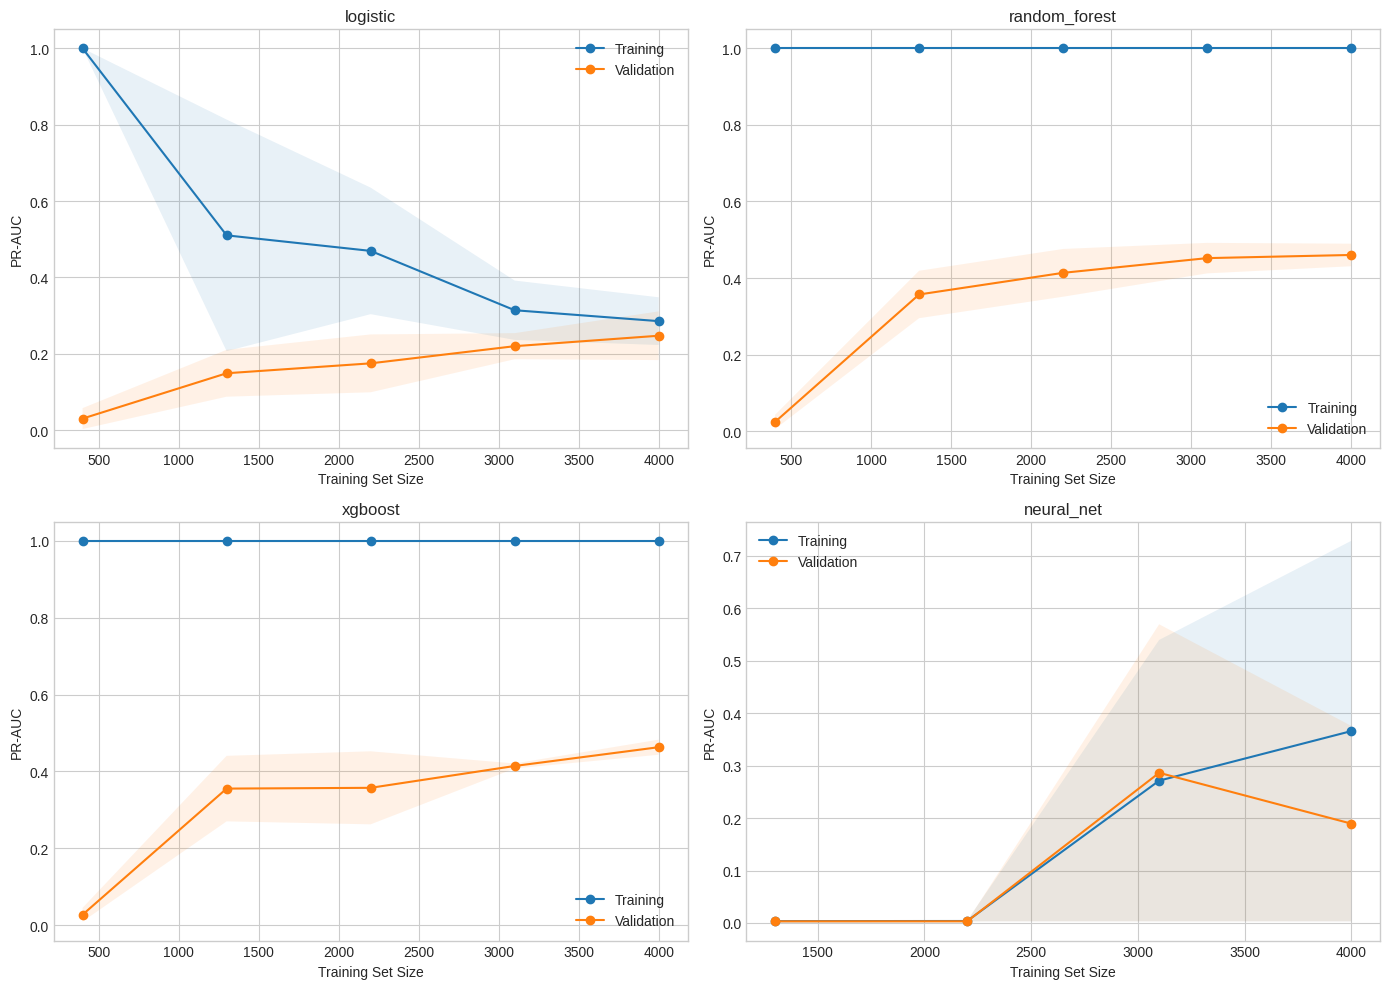


--- Finding: Overfitting Analysis ---


,model,train_pr_auc,val_pr_auc,gap,status
0,logistic,0.285576,0.247370,0.038206,UNDERFIT
1,random_forest,1.000000,0.460262,0.539738,OVERFIT
2,xgboost,1.000000,0.462976,0.537024,OVERFIT
3,neural_net,0.365768,0.189445,0.176323,OVERFIT


Overfitting detected: random_forest, xgboost, neural_net - need more regularization
Underfitting detected: logistic - models too simple


In [7]:
# Learning curves for ALL models (using PR-AUC, 2-fold CV)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

overfit_results = []

for idx, model_type in enumerate(ModelType):
    config = TrainConfig(model_type=model_type, cv_folds=2)
    trainer = Trainer(config)
    
    lc = trainer.get_learning_curve(X_sample, y_sample, scoring='average_precision')
    
    ax = axes[idx]
    ax.plot(lc['train_sizes'], lc['train_mean'], 'o-', label='Training')
    ax.fill_between(lc['train_sizes'], 
                    np.array(lc['train_mean']) - np.array(lc['train_std']),
                    np.array(lc['train_mean']) + np.array(lc['train_std']), alpha=0.1)
    ax.plot(lc['train_sizes'], lc['val_mean'], 'o-', label='Validation')
    ax.fill_between(lc['train_sizes'],
                    np.array(lc['val_mean']) - np.array(lc['val_std']),
                    np.array(lc['val_mean']) + np.array(lc['val_std']), alpha=0.1)
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('PR-AUC')
    ax.set_title(f'{model_type.value}')
    ax.legend()
    ax.grid(True)
    
    # Calculate overfitting gap
    train_final = lc['train_mean'][-1]
    val_final = lc['val_mean'][-1]
    gap = train_final - val_final
    
    overfit_results.append({
        'model': model_type.value,
        'train_pr_auc': train_final,
        'val_pr_auc': val_final,
        'gap': gap,
        'status': 'OVERFIT' if gap > 0.15 else ('UNDERFIT' if val_final < 0.3 else 'OK')
    })

plt.tight_layout()
plt.show()

# Dynamic finding
print("\n--- Finding: Overfitting Analysis ---")
overfit_df = pd.DataFrame(overfit_results)
display(overfit_df)

overfit_models = overfit_df[overfit_df['status'] == 'OVERFIT']['model'].tolist()
underfit_models = overfit_df[overfit_df['status'] == 'UNDERFIT']['model'].tolist()

if overfit_models:
    print(f"Overfitting detected: {', '.join(overfit_models)} - need more regularization")
if underfit_models:
    print(f"Underfitting detected: {', '.join(underfit_models)} - models too simple")
if not overfit_models and not underfit_models:
    print("All models generalize well.")

/home/heliya/Desktop/fraud-detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/heliya/Desktop/fraud-detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

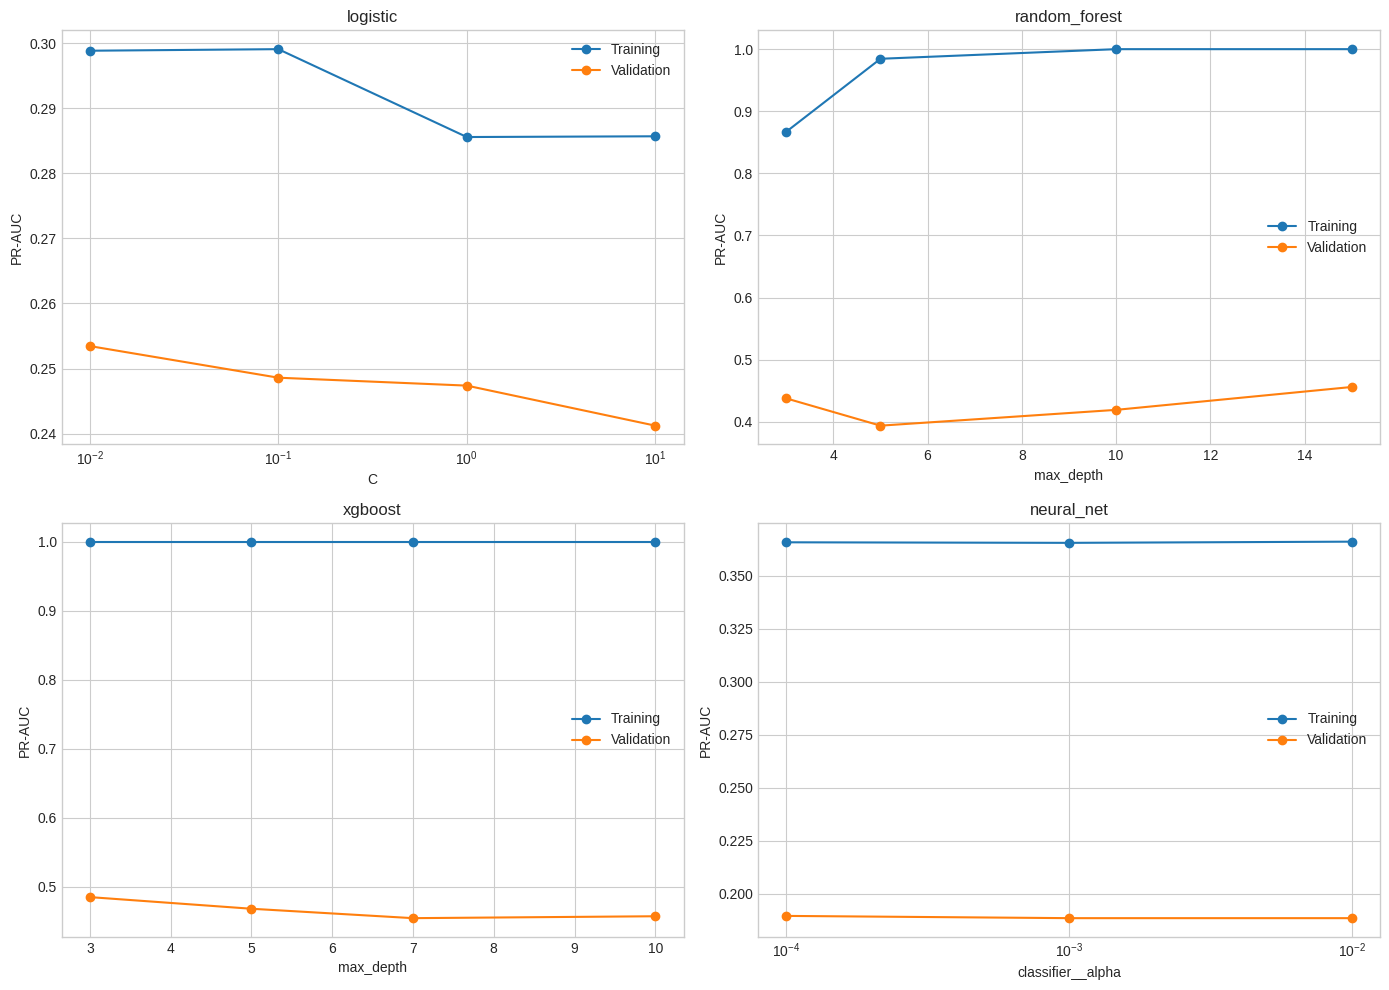


--- Finding: Optimal Hyperparameters ---
logistic: C=0.01 (val PR-AUC=0.253)
random_forest: max_depth=15 (val PR-AUC=0.456)
xgboost: max_depth=3 (val PR-AUC=0.485)
neural_net: classifier__alpha=0.0001 (val PR-AUC=0.189)


In [8]:
# Validation curves for key hyperparameter of each model (using PR-AUC, 2-fold CV)
param_configs = {
    ModelType.LOGISTIC: ('C', [0.01, 0.1, 1, 10]),
    ModelType.RANDOM_FOREST: ('max_depth', [3, 5, 10, 15]),
    ModelType.XGBOOST: ('max_depth', [3, 5, 7, 10]),
    ModelType.NEURAL_NET: ('classifier__alpha', [0.0001, 0.001, 0.01]),
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

optimal_params = {}

for idx, model_type in enumerate(ModelType):
    config = TrainConfig(model_type=model_type, cv_folds=2)
    trainer = Trainer(config)
    
    param_name, param_range = param_configs[model_type]
    
    vc = trainer.get_validation_curve(X_sample, y_sample, param_name=param_name, param_range=param_range, scoring='average_precision')
    
    ax = axes[idx]
    ax.plot(param_range, vc['train_mean'], 'o-', label='Training')
    ax.plot(param_range, vc['val_mean'], 'o-', label='Validation')
    ax.set_xlabel(param_name)
    ax.set_ylabel('PR-AUC')
    ax.set_title(f'{model_type.value}')
    ax.legend()
    ax.grid(True)
    if param_name == 'C' or param_name == 'classifier__alpha':
        ax.set_xscale('log')
    
    # Find optimal value
    best_idx = np.argmax(vc['val_mean'])
    optimal_params[model_type.value] = {
        'param': param_name,
        'optimal_value': param_range[best_idx],
        'val_pr_auc': vc['val_mean'][best_idx]
    }

plt.tight_layout()
plt.show()

# Dynamic finding
print("\n--- Finding: Optimal Hyperparameters ---")
for model, info in optimal_params.items():
    print(f"{model}: {info['param']}={info['optimal_value']} (val PR-AUC={info['val_pr_auc']:.3f})")

## 6. PCA (Proof of Concept)

With only 16 features, PCA likely won't improve performance. This is included to demonstrate the technique.

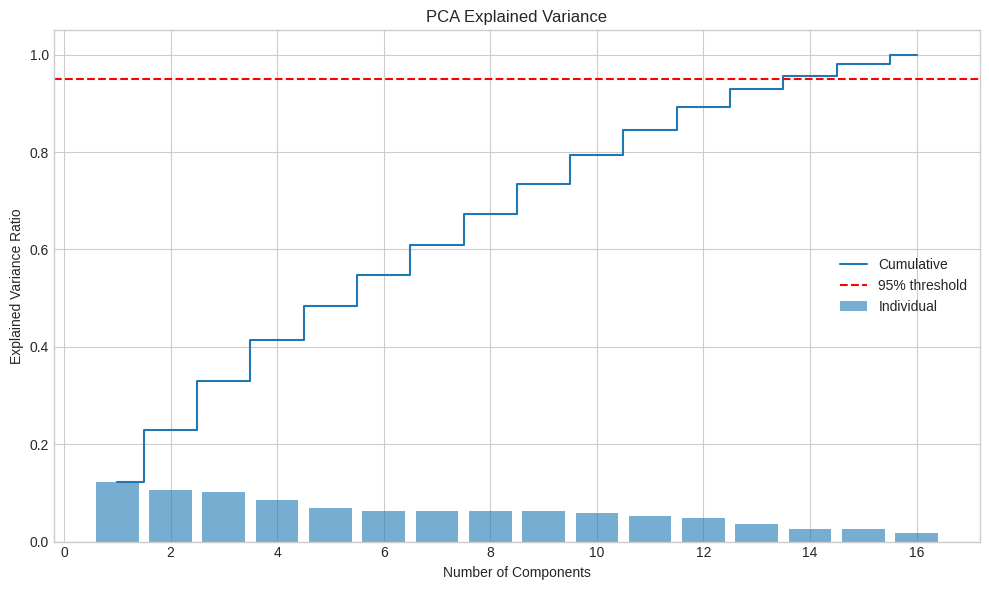


--- Finding ---
Components for 95% variance: 14 out of 16
Only 12% reduction possible. PCA not beneficial here.
Keeping all features.


In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scale features first (PCA sensitive to scale)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Fit PCA
pca = PCA()
pca.fit(X_train_scaled)

# Plot explained variance
plt.figure(figsize=(10, 6))
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), 
        pca.explained_variance_ratio_, alpha=0.6, label='Individual')
plt.step(range(1, len(cumsum) + 1), cumsum, where='mid', label='Cumulative')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

n_95 = np.argmax(cumsum >= 0.95) + 1
n_total = len(pca.explained_variance_ratio_)

# Dynamic finding
print(f"\n--- Finding ---")
print(f"Components for 95% variance: {n_95} out of {n_total}")
reduction_pct = (1 - n_95/n_total) * 100
if reduction_pct < 20:
    print(f"Only {reduction_pct:.0f}% reduction possible. PCA not beneficial here.")
    print("Keeping all features.")
else:
    print(f"Could reduce to {n_95} components ({reduction_pct:.0f}% reduction).")

## 7. Hyperparameter Tuning

In [10]:
# Tune XGBoost with reduced param grid (2-fold CV for speed)
# Smaller grid: 2*2*2*2*2 = 32 combinations instead of 432
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.1],
    'scale_pos_weight': [10, 50],
    'reg_alpha': [0, 0.1],      # L1 regularization
    'reg_lambda': [1, 2],        # L2 regularization
}

with mlflow.start_run(run_name="hyperparameter_tuning"):
    config = TrainConfig(model_type=ModelType.XGBOOST, cv_folds=2)
    trainer = Trainer(config)

    tune_result = trainer.tune(X_train, y_train, param_grid=param_grid, scoring='average_precision')
    
    mlflow.log_params(tune_result['best_params'])
    mlflow.log_metric("best_cv_pr_auc", tune_result['best_score'])
    
    print("Best parameters:")
    for k, v in tune_result['best_params'].items():
        print(f"  {k}: {v}")
    print(f"\nBest CV PR-AUC: {tune_result['best_score']:.4f}")
    
    # Dynamic finding on regularization
    print(f"\n--- Finding ---")
    bp = tune_result['best_params']
    reg_alpha = bp.get('reg_alpha', 0)
    reg_lambda = bp.get('reg_lambda', 1)
    if reg_alpha > 0 or reg_lambda > 1:
        print(f"Regularization active: L1={reg_alpha}, L2={reg_lambda}")
    else:
        print("Minimal regularization needed.")

Tuning xgboost: 32 combinations × 2 folds = 64 fits
Fitting 2 folds for each of 32 candidates, totalling 64 fits


/home/heliya/Desktop/fraud-detection/.venv/lib/python3.12/site-packages/xgboost/core.py:774: UserWarning: [21:16:45] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/heliya/Desktop/fraud-detection/.venv/lib/python3.12/site-packages/xgboost/core.py:774: UserWarning: [21:17:25] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the de

Best score: 0.8664
Best parameters:
  learning_rate: 0.1
  max_depth: 7
  n_estimators: 200
  reg_alpha: 0
  reg_lambda: 1
  scale_pos_weight: 10

Best CV PR-AUC: 0.8664

--- Finding ---
Minimal regularization needed.


## 8. Save Model

In [13]:
import joblib

# Save model
model_path = MODELS_DIR / 'fraud_detector.joblib'
joblib.dump(trainer.model, model_path)
print(f"Model saved to {model_path}")

# Save config (threshold will be determined in evaluation)
config_path = MODELS_DIR / 'model_config.txt'
with open(config_path, 'w') as f:
    f.write(f"model_type={config.model_type.value}\n")
    for k, v in tune_result['best_params'].items():
        f.write(f"{k}={v}\n")
print(f"Config saved to {config_path}")



Model saved to ../models/fraud_detector.joblib
Config saved to ../models/model_config.txt


In [14]:
# Training summary
print("=" * 50)
print("TRAINING SUMMARY")
print("=" * 50)

print(f"\nBest Model: {config.model_type.value}")
print(f"Best Parameters: {tune_result['best_params']}")
print(f"Best CV PR-AUC: {tune_result['best_score']:.4f}")

print(f"\nKey Decisions:")
print(f"  - Metric: PR-AUC (better for imbalanced data)")
print(f"  - Imbalance handling: {'class_weights' if pr_auc_weights >= pr_auc_smote else 'SMOTE'}")
print(f"  - Regularization: L1={tune_result['best_params'].get('reg_alpha', 0)}, L2={tune_result['best_params'].get('reg_lambda', 1)}")

print(f"\nModel saved to: {model_path}")


TRAINING SUMMARY

Best Model: xgboost
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 10}
Best CV PR-AUC: 0.8664

Key Decisions:
  - Metric: PR-AUC (better for imbalanced data)
  - Imbalance handling: class_weights
  - Regularization: L1=0, L2=1

Model saved to: ../models/fraud_detector.joblib
